# Sarima Results

Below contains the results from the first pass at SARIMA modeling.

Feel free to scroll down to 'Analyzing Results'

In [1]:
import pandas as pd
import pmdarima as pm

import os.path
from os import path
import numpy as np
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgb

In [2]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [3]:
df = pd.read_pickle('1.collect_data/data_files/1hr.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

blockface_detail = pd.read_csv('1.collect_data/blockface_detail.csv')


In [4]:
df['Dummy'] = 0
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':-1, 
}

In [5]:
start_date = '2019-01-01'
baseline_columns = ['Dummy', 'SourceElementKey']

blocks_run = []
arima_smapes = []
gbm_smapes = []
arima_rmses = []
sample_len = []
mdl_order = []
test_vals = []
arima_preds = []
gbm_preds = []

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = 'arima_results/arima.%d.pkl' % block
    if path.exists(block_file):
        mask = (df['SourceElementKey'] == block) & (df['OccupancyDateTime'] > (start_date))

        curr = df[mask]
        time_chunks_per_day = curr.groupby(curr.OccupancyDateTime.dt.dayofyear).count().SourceElementKey.max()
        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]
        
        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)
        preds = mdl.predict(n_periods=test.shape[0])
        mdl_dict = mdl.to_dict()
#         print(block, mdl_dict['order'], mdl_dict['seasonal_order'])
        mdl_order.append((mdl_dict['order'], mdl_dict['seasonal_order']))



        arima_smape = smape_error(preds, test)

        test_vals.append(test)
        arima_preds.append(preds)
        
        # Build a Gradient Boost Model, but with no parameters. This should just 'predict' as the mean value


        lgb_train = lgb.Dataset(data=df_train[baseline_columns], 
                                label=df_train['PercentOccupied'], 
                                feature_name=baseline_columns, 
                               params={'verbose': -1})
        lgb_test = lgb.Dataset(data=df_test[baseline_columns], 
                               label=df_test['PercentOccupied'], 
                               feature_name=baseline_columns, 
                               reference=lgb_train,
                              params={'verbose': -1})
        gbm = lgb.train(params,
                    lgb_train,
                   valid_sets=lgb_test,
                       verbose_eval=False)
        
        # calculate errors
        gbm_pred = gbm.predict(df_test[baseline_columns], num_iteration=gbm.best_iteration)
        gbm_smape = smape_error(gbm_pred, df_test['PercentOccupied'])
        ar_rmse = np.sqrt(mean_squared_error(test, preds))
#         print("Test RMSE: %.3f\t SMAPE: %.3f\t GBM SMAPE: %.3f" % (
#             arima_rmse, arima_smape, gbm_smape))
        
        # Append Results
        arima_rmses.append(ar_rmse)
        blocks_run.append(block)
        arima_smapes.append(arima_smape)
        gbm_smapes.append(gbm_smape)
        sample_len.append(num_split)
        gbm_preds.append(gbm_pred)


In [6]:
print(np.mean(arima_smapes), np.mean(gbm_smapes))

28.49609579439029 27.951776152829428


In [7]:
model_summary_df = pd.DataFrame({'ArimaSmapeErrors': arima_smapes,
                                'GBMSmapeErrors':gbm_smapes,
                                'TrainingSetLength':sample_len,
                                 'ArimaRMSEs':arima_rmses,
                                 'ModelOrder':mdl_order,
                                 'TestVals':test_vals,
                                 'ArimaPreds':arima_preds,
                                 'GBMPreds':gbm_preds,
                                },
                               index=blocks_run)
model_summary_df[['NonSeasonal', 'Seasonal']] = pd.DataFrame(model_summary_df['ModelOrder'].tolist(), index=model_summary_df.index) 
model_summary_df[['p', 'd', 'q']] = pd.DataFrame(model_summary_df['NonSeasonal'].tolist(), index=model_summary_df.index)
model_summary_df[['P', 'D', 'Q', 'm']] = pd.DataFrame(model_summary_df['Seasonal'].tolist(), index=model_summary_df.index)



In [8]:
model_summary_df.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,NonSeasonal,Seasonal,p,d,q,P,D,Q,m
1001,30.826775,34.434702,1427,0.233241,"((3, 1, 3), (2, 0, 2, 10))",22617 0.247984 22618 0.225269 22619 0...,"[0.25770238599725415, 0.24653643153017435, 0.1...","[0.29248498129242667, 0.29248498129242667, 0.2...","(3, 1, 3)","(2, 0, 2, 10)",3,1,3,2,0,2,10
1002,30.916092,37.279208,1427,0.196573,"((1, 1, 1), (1, 0, 1, 10))",45847 0.237630 45848 0.251563 45849 0...,"[0.27159805632744266, 0.29349456991503353, 0.0...","[0.27232191637687037, 0.27232191637687037, 0.2...","(1, 1, 1)","(1, 0, 1, 10)",1,1,1,1,0,1,10
1006,23.858915,33.132488,1696,0.172062,"((0, 0, 0), (4, 0, 2, 12))",95291 0.507143 95292 0.326190 95293 0...,"[0.5058257663304873, 0.342148345180791, 0.2369...","[0.3211730913292586, 0.3211730913292586, 0.321...","(0, 0, 0)","(4, 0, 2, 12)",0,0,0,4,0,2,12
1009,35.346899,38.520762,1712,0.219138,"((1, 1, 1), (3, 0, 3, 12))",123176 0.436095 123177 0.387810 123178 ...,"[0.45847873893672186, 0.4364527174875548, 0.18...","[0.29087346552916865, 0.29087346552916865, 0.2...","(1, 1, 1)","(3, 0, 3, 12)",1,1,1,3,0,3,12
1010,19.594693,24.154482,1712,0.226841,"((1, 1, 1), (1, 0, 1, 12))",151069 0.620686 151070 0.581863 151071 ...,"[0.6189713903017217, 0.5709288061900901, 0.341...","[0.5597597884610469, 0.5597597884610469, 0.559...","(1, 1, 1)","(1, 0, 1, 12)",1,1,1,1,0,1,12


# Analyzing Results

Let's take a look at the results and see how the Sarima Results compare to predicting simply based on the mean (SIMPLE):

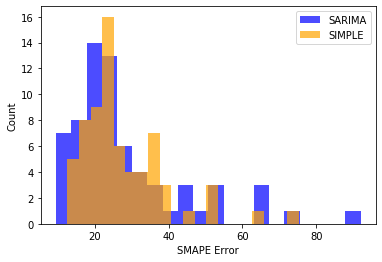

In [9]:
fig, ax = plt.subplots()
ax.hist(model_summary_df['ArimaSmapeErrors'], bins=20,color = 'b', alpha = .7, label='SARIMA')
ax.hist(model_summary_df['GBMSmapeErrors'], bins=20, color = 'orange', alpha = .7, label='SIMPLE')
ax.set_xlabel('SMAPE Error')
ax.set_ylabel('Count')
plt.legend()
plt.show()

Looking at the figure above, it appears that using SARIMA gives better errors for some blocks, and worse errors for other blocks. I shall inspect the data further to see what may be causing this.

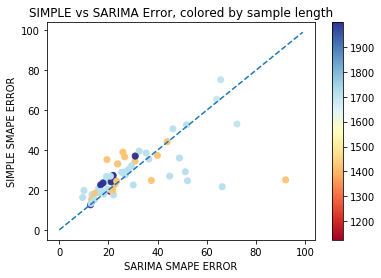

In [10]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(model_summary_df['ArimaSmapeErrors'], 
                model_summary_df['GBMSmapeErrors'], 
                c=model_summary_df['TrainingSetLength'], cmap=cm)
ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
ax.set_title('SIMPLE vs SARIMA Error, colored by sample length')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.show()

Above, sample size does not appear to be correlated with the error

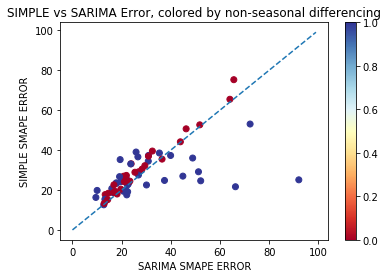

In [11]:
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')

im = ax.scatter(model_summary_df['ArimaSmapeErrors'], 
                model_summary_df['GBMSmapeErrors'], 
                c=model_summary_df['d'], cmap=cm)
ax.set_title('SIMPLE vs SARIMA Error, colored by non-seasonal differencing')

ax.set_xlabel('SARIMA SMAPE ERROR')
ax.set_ylabel('SIMPLE SMAPE ERROR')
fig.colorbar(im, ax=ax)
ax.plot(np.arange(100), np.arange(100), '--')
plt.show()

Above, the worst SARIMA model errors are those with a differencing of one. Potentially, allowing no differencing will improve these models. Below, we can see the mean errors for those with and without non-seasonal differencing.

In [12]:
model_summary_df[model_summary_df['d'] == 0].mean()

ArimaSmapeErrors       27.367228
GBMSmapeErrors         30.457772
TrainingSetLength    1731.068966
ArimaRMSEs              0.232206
p                       0.620690
d                       0.000000
q                       1.034483
P                       2.310345
D                       0.000000
Q                       2.068966
m                      12.137931
dtype: float64

In [13]:
model_summary_df[model_summary_df['d'] == 1].mean()

ArimaSmapeErrors       29.335510
GBMSmapeErrors         26.088343
TrainingSetLength    1590.435897
ArimaRMSEs              0.291269
p                       1.435897
d                       1.000000
q                       1.102564
P                       1.794872
D                       0.000000
Q                       1.846154
m                      11.487179
dtype: float64

## Inspecting some individual Blocks

#### Block A

In [14]:
ex_row = model_summary_df[model_summary_df['ArimaSmapeErrors'] < model_summary_df['GBMSmapeErrors']].iloc[0]
ex_row.ModelOrder

((3, 1, 3), (2, 0, 2, 10))

Below is a block that the SARIMA model performs well with. It appears to capture the daily periodicity, but not the spikes on certain days.

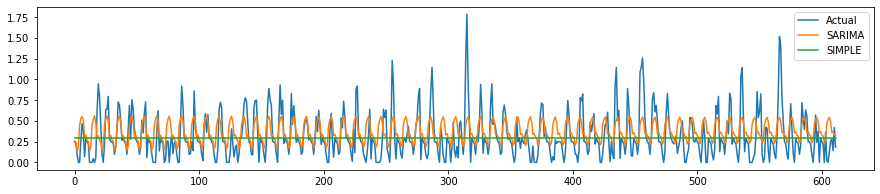

In [15]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row.TestVals.values, label='Actual')
ax.plot(ex_row.ArimaPreds, label='SARIMA')
ax.plot(ex_row.GBMPreds, label='SIMPLE')
plt.legend()
plt.show()


#### Block B

In [16]:
ex_row2 = model_summary_df[model_summary_df['ArimaSmapeErrors'] > model_summary_df['GBMSmapeErrors']].iloc[0]
ex_row2.ModelOrder

((1, 0, 2), (1, 0, 1, 12))

Below is a block that the SARIMA model performs poorly with. The daily trend does not appear as regular as the block above.

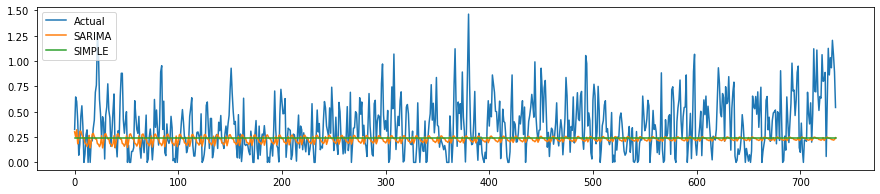

In [17]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row2.TestVals.values, label='Actual')
ax.plot(ex_row2.ArimaPreds, label='SARIMA')
ax.plot(ex_row2.GBMPreds, label='SIMPLE')
plt.legend()
plt.show()

#### Block C

In [18]:
ex_row3 = model_summary_df[(model_summary_df['ArimaSmapeErrors'] - model_summary_df['GBMSmapeErrors']) > 20].iloc[0]
ex_row3.ModelOrder

((0, 1, 0), (2, 0, 2, 12))

Below is a model with seasonal differencing = 1, which performs quite poorly. We can see that the mean is not trending downwards over time, which leads to a poor SARIMA model with d=1.

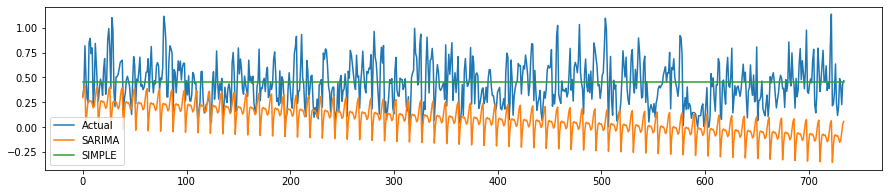

In [19]:
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(ex_row3.TestVals.values, label='Actual')
ax.plot(ex_row3.ArimaPreds, label='SARIMA')
ax.plot(ex_row3.GBMPreds, label='SIMPLE')
plt.legend()
plt.show()

## Next Steps

Things I would like to test out:
   
   * Allowing no differencing (setting $d=0$)
   * Adding Exogenous regressors, to see if this can help predict the spikes (SARIMAX model)
   * Use Tree-based models to predict on the residuals from the SARIMA model
   
Things that may help even out the sharp, potentially random, peaks:

   * Predict based on blocks within certain radius. Potentially, an individual block cannot be predicted so accurately because people may choose to find parking within a certain radius, instead of a specific block.
